## train.ipynb: Define and Train the model
- 把tensorflow1 改成tensorflow2

In [16]:
# Import the necessary libraries
import numpy as np
import scipy
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cross_validation import StratifiedKFold

In [3]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm, 
# the number of retained features  n
numPCAcomponents = 30
# Patches windows size
windowSize = 5
# The proportion of Test sets
testRatio = 0.50

In [4]:
# load Preprocessed data from file
X_train = np.load("./predata/X_train_WS_" 
                  + str(windowSize) + "_PCA_" + str(numPCAcomponents) + 
                  "_testRatio_" + str(testRatio)  + ".npy")
y_train = np.load("./predata/y_train_WS_" 
                  + str(windowSize) + "_PCA_" + str(numPCAcomponents) + 
                  "_testRatio_" + str(testRatio) + ".npy")
X_test = np.load("./predata/X_test_WS_" 
                  + str(windowSize) + "_PCA_" + str(numPCAcomponents) + 
                 "_testRatio_" + str(testRatio)  + ".npy")
y_test = np.load("./predata/y_test_WS_" 
                  + str(windowSize) + "_PCA_" + str(numPCAcomponents) + 
                 "_testRatio_" + str(testRatio) + ".npy")

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19788, 5, 5, 30), (19788,), (5125, 5, 5, 30), (5125,))

In [6]:
# Reshape data into (numberofsumples, channels, height, width)

# convert class labels to on-hot encoding
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

# Define the input shape 
input_shape= X_train[0].shape
print(input_shape)

# number of filters
C1 = 3*numPCAcomponents
C1

(5, 5, 30)


90

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19788, 5, 5, 30), (19788, 16), (5125, 5, 5, 30), (5125, 16))

In [8]:
# Define the model structure
model = Sequential()

model.add(Conv2D(C1, (3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(3*C1, (3, 3), activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(6*numPCAcomponents, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 3, 90)          24390     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 270)         218970    
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 270)         0         
_________________________________________________________________
flatten (Flatten)            (None, 270)               0         
_________________________________________________________________
dense (Dense)                (None, 180)               48780     
_________________________________________________________________
dropout_1 (Dropout)          (None, 180)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2

In [10]:
# Define optimization and train method
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=25, 
                              min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="checkpoint.hdf5", verbose=1, 
                              save_best_only=False)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
                              metrics=['accuracy'])

In [11]:
# Start to train model 
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=5, 
                    verbose=1, 
                    validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, checkpointer],
                    shuffle=True)

Epoch 1/5
615/619 [============================>.] - ETA: 0s - loss: 1.3273 - accuracy: 0.5894
Epoch 00001: saving model to checkpoint.hdf5
619/619 [==============================] - 3s 5ms/step - loss: 1.3229 - accuracy: 0.5906 - val_loss: 0.8190 - val_accuracy: 0.7278
Epoch 2/5
614/619 [============================>.] - ETA: 0s - loss: 0.4682 - accuracy: 0.8391
Epoch 00002: saving model to checkpoint.hdf5
619/619 [==============================] - 3s 4ms/step - loss: 0.4679 - accuracy: 0.8393 - val_loss: 0.5233 - val_accuracy: 0.8146
Epoch 3/5
613/619 [============================>.] - ETA: 0s - loss: 0.2838 - accuracy: 0.9066
Epoch 00003: saving model to checkpoint.hdf5
619/619 [==============================] - 3s 4ms/step - loss: 0.2831 - accuracy: 0.9068 - val_loss: 0.3943 - val_accuracy: 0.8535
Epoch 4/5
610/619 [============================>.] - ETA: 0s - loss: 0.2004 - accuracy: 0.9337
Epoch 00004: saving model to checkpoint.hdf5
619/619 [==============================] - 3s 4

In [12]:
# save the model with h5py
import h5py
from tensorflow.keras.models import load_model
model.save('./model/HSI_model.h5')

In [13]:
# using plot_model module to save the model figure
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='./model/model.png', show_shapes=True)
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


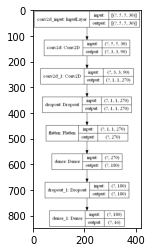

In [23]:
# show the model figure
model_img = plt.imread('./model/model.png')
# plt.figure(dpi=180)
plt.imshow(model_img)
plt.show()

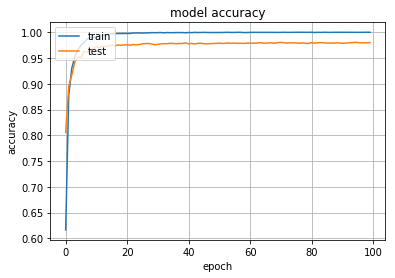

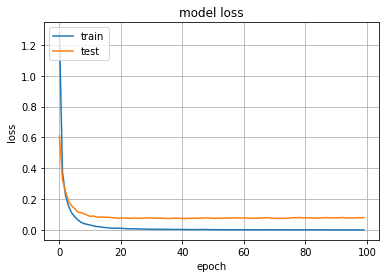

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
plt.savefig("./result/model_accuracy_100.svg")
plt.show()

# summarize history for loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
plt.savefig("./result/model_loss_100.svg")
plt.show()